In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import colorcet as cc

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [4]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

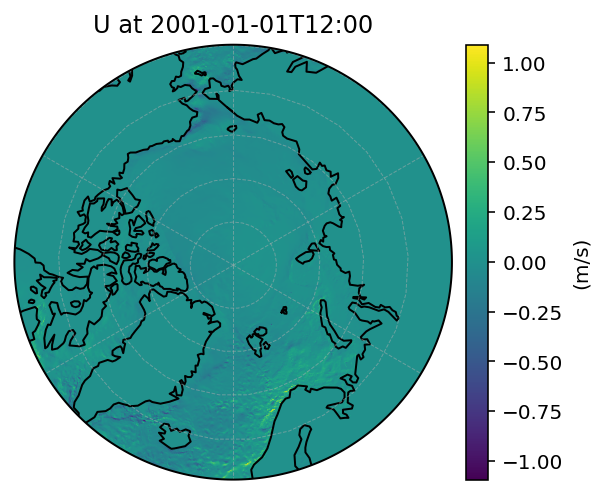

In [7]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [5]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [7]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [8]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

In [9]:
myBins.particle_count(myParts)

array([250,   0, 254, ..., 259, 255, 257])

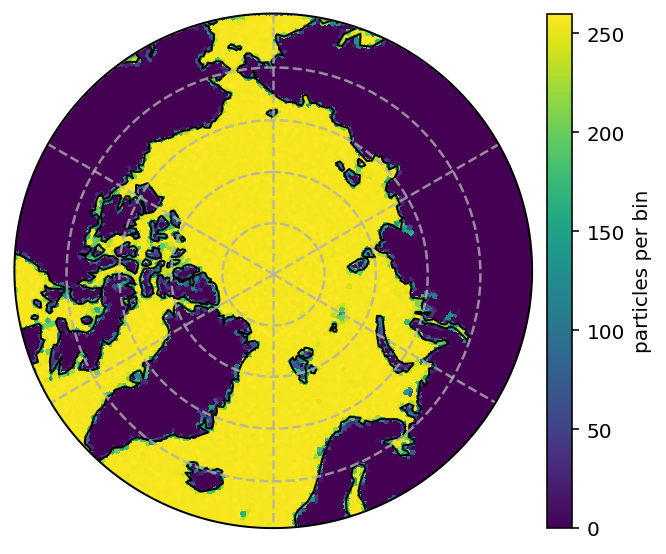

In [10]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "particles per bin",
                                             size=(5,5))

In [10]:
runName = "Rcmems_Pico11_S2017-12-1_D90_DT20_ODT24"

## Markov-time

In [11]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"

In [ ]:
transMat_20180301 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(90, 'D'),
                                               mask = myBins.oceanMask)
transMat_20180301.save_counter(matdir + f"masked_counter_{runName}_Cico7")
transMat_20180301.save_network(netdir + f"masked_network_{runName}_Cico7.net")

In [60]:
ice_ds = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201803.nc")

In [12]:
transMat_20180301 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")

In [70]:
comName = runName + "_Cico7_mt1"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.2524344486574263
Global Mixing Parameter 0.25759783841344286


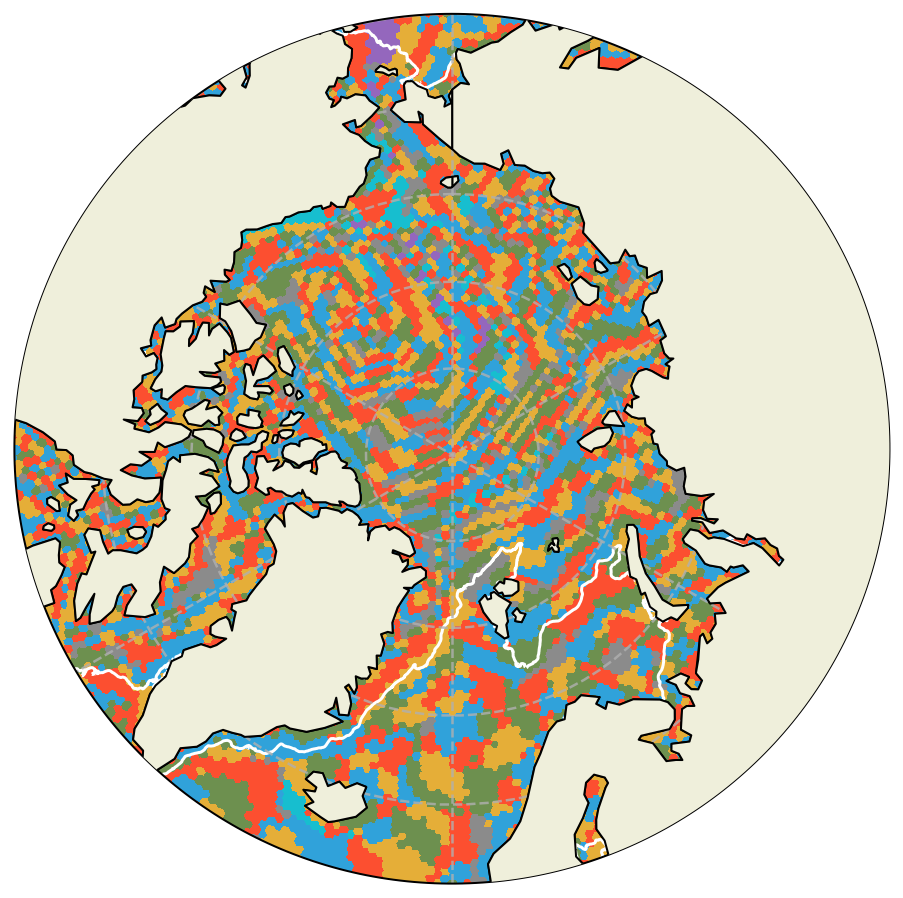

In [71]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             size = (5,5),
                                             #export = f"{comName}.png",
                                             cbar=False,
                                             polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

In [72]:
comName = runName + "_Cico7_mt2"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.49106242866162486
Global Mixing Parameter 0.31416263019566976


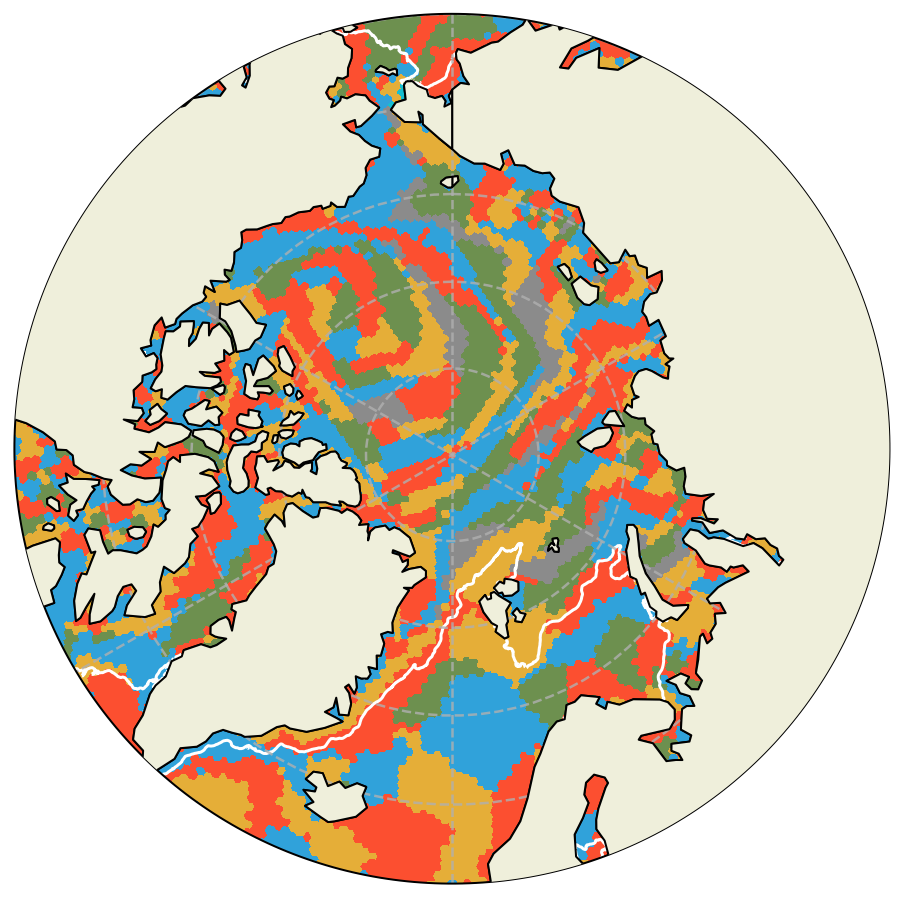

In [73]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             size = (5,5),
                                             #export = f"{comName}.png",
                                             cbar=False,
                                             polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

In [74]:
comName = runName + "_Cico7_mt3"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.6337976573830161
Global Mixing Parameter 0.31726743363317833


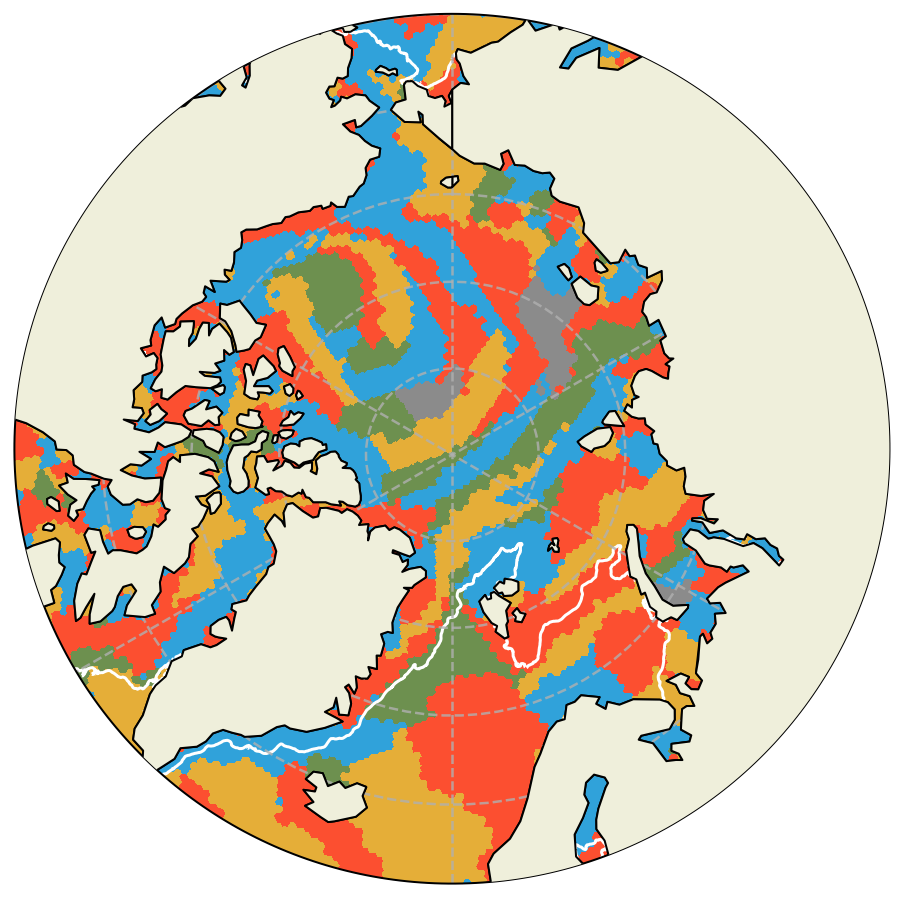

In [75]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             size = (5,5),
                                             #export = f"{comName}.png",
                                             cbar=False,
                                             polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

In [ ]:
transMat_20180301_subD30 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [70]:
comName = runName + "_Cico7_subD30_mt1"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301_subD30);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301_subD30);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.2524344486574263
Global Mixing Parameter 0.25759783841344286


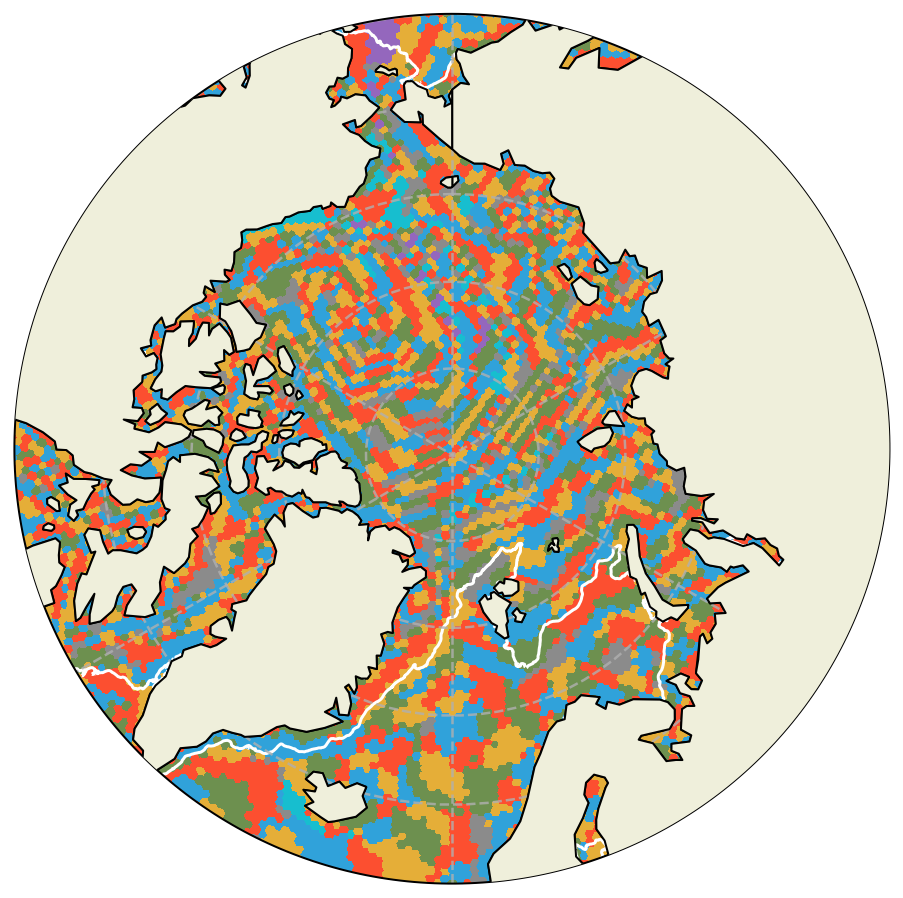

In [71]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             size = (5,5),
                                             #export = f"{comName}.png",
                                             cbar=False,
                                             polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

In [72]:
comName = runName + "_Cico7_subD30_mt2"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301_subD30);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301_subD30);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.49106242866162486
Global Mixing Parameter 0.31416263019566976


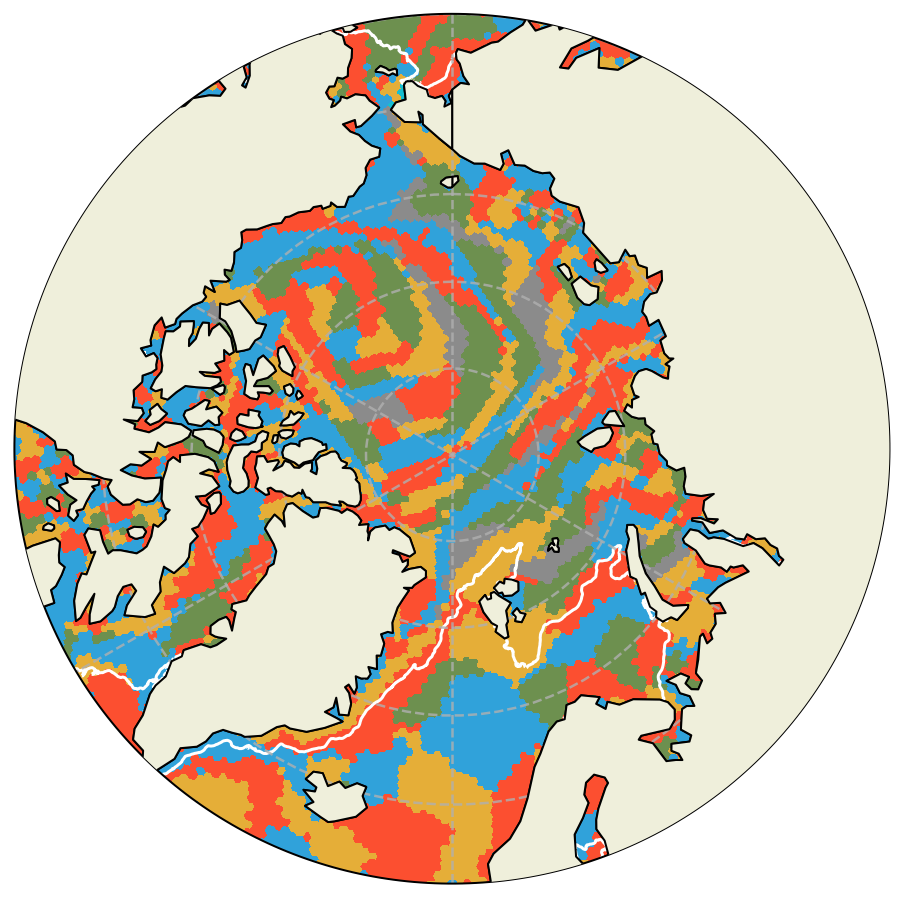

In [73]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             size = (5,5),
                                             #export = f"{comName}.png",
                                             cbar=False,
                                             polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

In [74]:
comName = runName + "_Cico7_subD30_mt3"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301_subD30);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301_subD30);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.6337976573830161
Global Mixing Parameter 0.31726743363317833


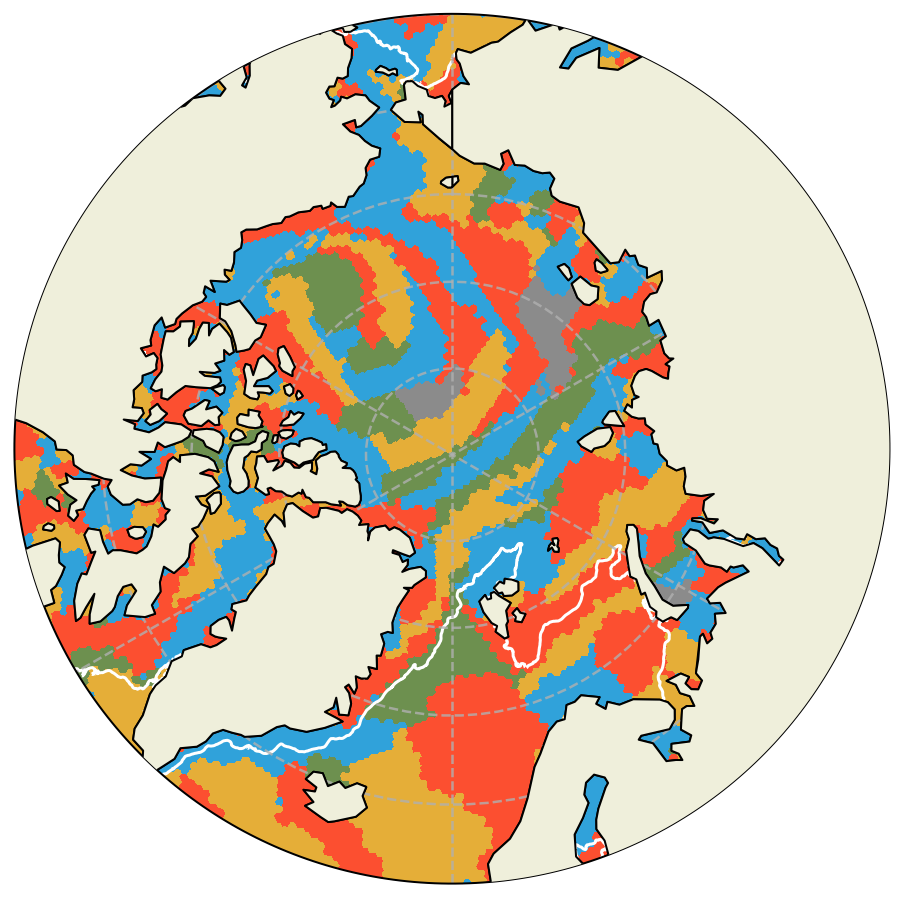

In [75]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                             size = (5,5),
                                             #export = f"{comName}.png",
                                             cbar=False,
                                             polar = True,
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')